# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет.

Задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. проанализировать основные признаки, наиболее сильно влияющие на отток;
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

* выделить целевые группы клиентов;

* предложить меры по снижению оттока;

* определить другие особенности взаимодействия с клиентами.

**Ход исследования**  

Исследование содержит следующие этапы:
1. Загрузка данных из файла.  
2. Предобработка данных.  
3. Построение модели прогнозирования оттока клиентов
4. Проведение кластеризации клиентов
5. Выводы и рекомендации.

## Загрузка данных

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats as st
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans



In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# чтение файла с данными и сохранение в переменной data
if os.path.exists('/datasets/gym_churn.csv'):
    data = pd.read_csv('/datasets/gym_churn.csv', sep = ',')
else:
    data = pd.read_csv('gym_churn.csv', sep = ',')

In [4]:
# просмотр первых пяти строк
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:

* gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);

* Group_visits — факт посещения групповых занятий;

* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;

* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;

* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

* Churn — факт оттока в текущем месяце.

In [5]:
# приведем названия признаков к нижнему регистру
data.columns = data.columns.str.lower()

## Проведение исследовательского анализа данных (EDA)

In [6]:
# изучим общую информацию о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Пропусков нет, все типы числовые.

In [7]:
# изучим средние значения и стандартные отклонения при помощи метода describe()
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В некоторых полях, можно наблюдать большое стандартное отклонение, у некоторых даже больше среднего значения, это говорит о большом разбросе значений в данных полях. 

In [8]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, 
# кто остался, при помощи метода groupby()
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Если посмотреть на среднее, то можно обозначит основные характерные черты тех, кто ушел в отток:
* не проживает и не работает в районе фитнес-клуба
* не являются сотрудником компании партнера
* не ходит на групповые занятия
* более молодые
* меньше пользуется другими услугами фитнес центра
* длительность текущего абонемента составляет менее 2ух месяцев
* лайфтайм меньше месяца
* посещение в неделю менее двух раз

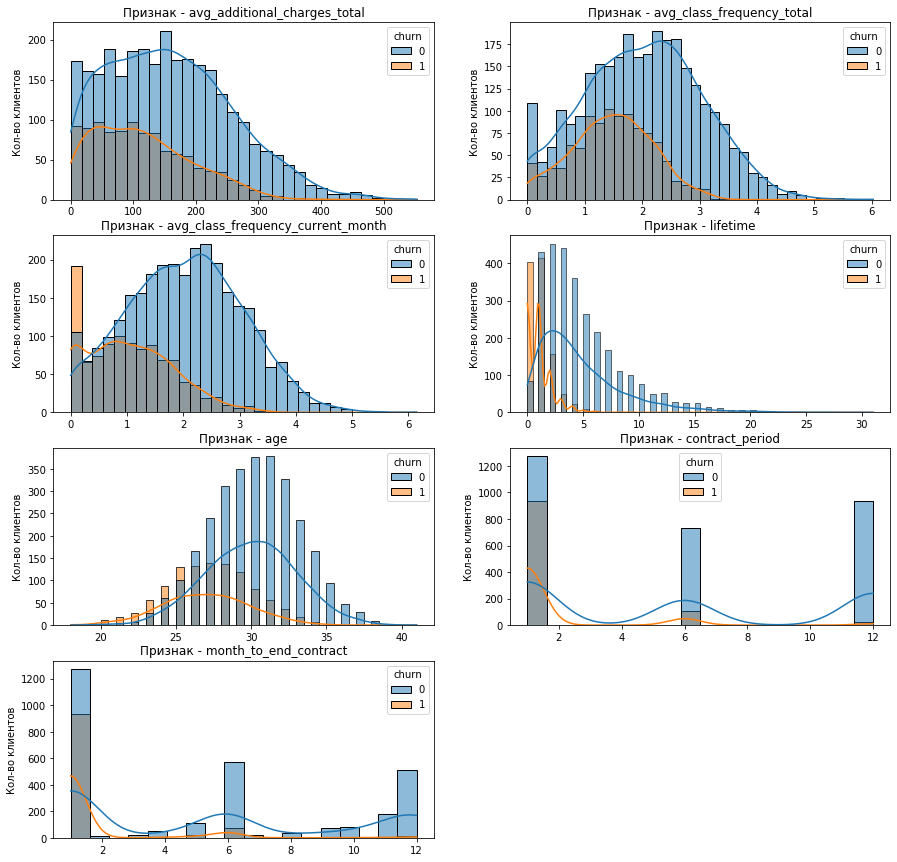

In [9]:
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']

col_count, row_count = 2, 4 # число рядов и столбцов в сетке графиков
plt.figure(figsize=(15, 15))
 
for i, f in enumerate(distplot_columns):           
    sns.histplot(data, x=data[f], hue='churn', palette="tab10", kde=True, ax = plt.subplot(row_count, col_count, i+1)) 
    plt.title(f'Признак - {f}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")

Графики подтверждают составленные выше характерные черты тех, кто ушел.

Так же из графиков видно:
* 'Avg_class_frequency_current_month', у тех кто ушел в отток большой всплеск около ноля. Слишком много тех кто за неделю не посетил фитнес ни разу. Похоже на выброс.
* По 'Lifetime' видно опять большой всплеск около 0-1, уходят те, кто недолго ходил в фитнес, так же имеет длинный хвост, что соответствует выбросам. В линейных моделях — выбросы могут серьёзно «перетянуть» зависимость на себя, поэтому удалим их.
* По 'Contract_period' видно, очень много тех кто ушел, имеют абонемент на 1 месяц.
* Так же уходят те, у кого до конца абонемента осталось меньше месяца.

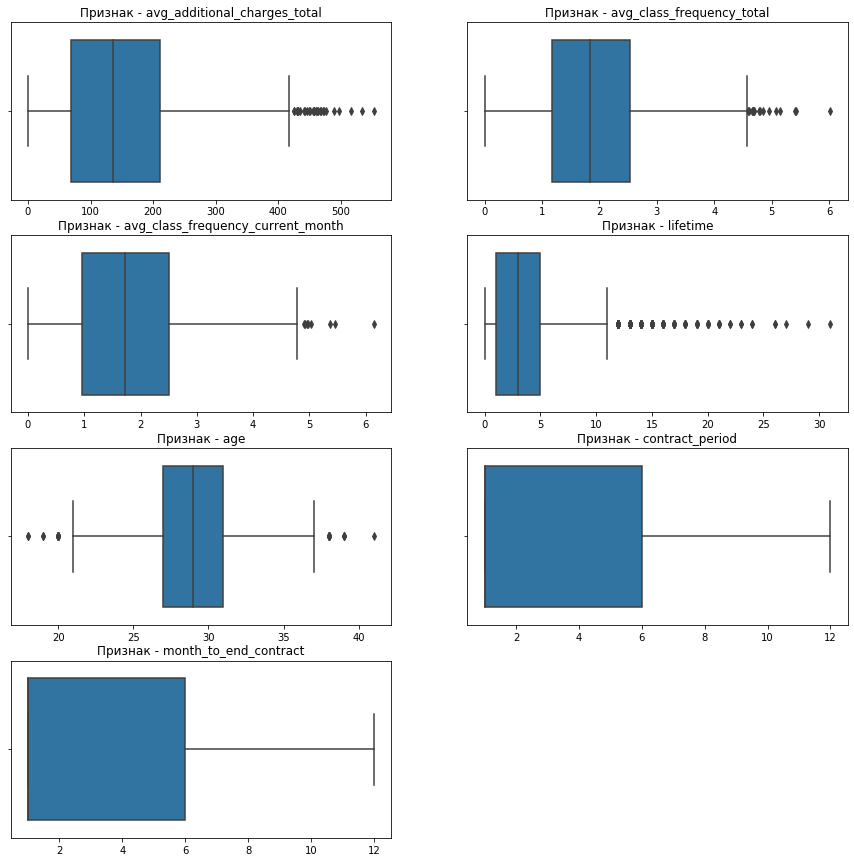

In [10]:
# посмотрим на выбросы при помощи boxplot
plt.figure(figsize=(15, 15))
for i, f in enumerate(distplot_columns):           
    sns.boxplot(data=data, x=data[f], palette="tab10", ax = plt.subplot(row_count, col_count, i+1)) 
    plt.title(f'Признак - {f}')
    plt.xlabel("")

In [11]:
# Посчитаем выборочные перцентили количества заказов на одного пользователя:
np.percentile(data['avg_additional_charges_total'], [95, 99])

array([323.44087589, 400.99612505])

In [12]:
np.percentile(data['lifetime'], [95, 99])

array([11., 17.])

In [13]:
np.percentile(data['avg_class_frequency_total'], [95, 99])

array([3.53564837, 4.19757925])

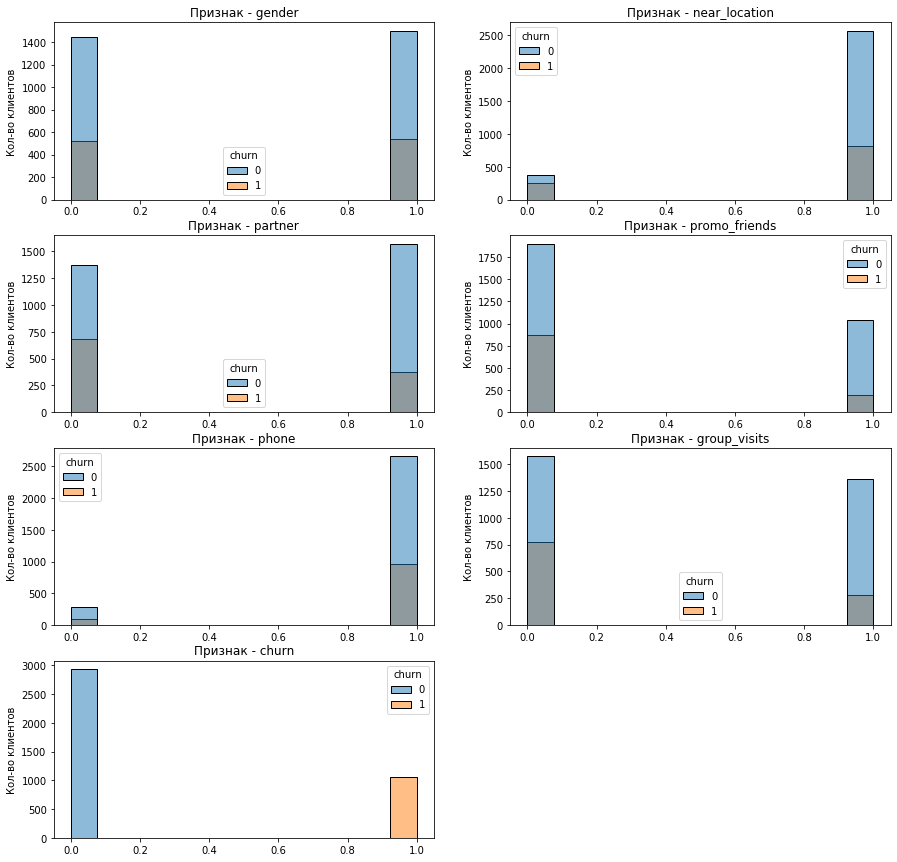

In [14]:
# построим гистограммы для столбцов имеющих булевые значения
distplot_columns_1 = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
plt.figure(figsize=(15, 15))
for i, f in enumerate(distplot_columns_1):           
    sns.histplot(data, x=data[f], hue='churn', palette="tab10", ax = plt.subplot(row_count, col_count, i+1)) 
    plt.title(f'Признак - {f}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")

* от пола нет зависимости остаются или уходят клиенты 
* остаются те, у которых фитнес рядом с домом или работой
* отток меньше у клиентов, являющимися сотрудниками компаний-партнеров
* остаются больше те, кто пришел не по акции "приведи друга"
* оставил клиент или нет телефон, тоже может служит сигналом, уйдет или останется он
* больше все таки  остаются клиенты, чем уходят

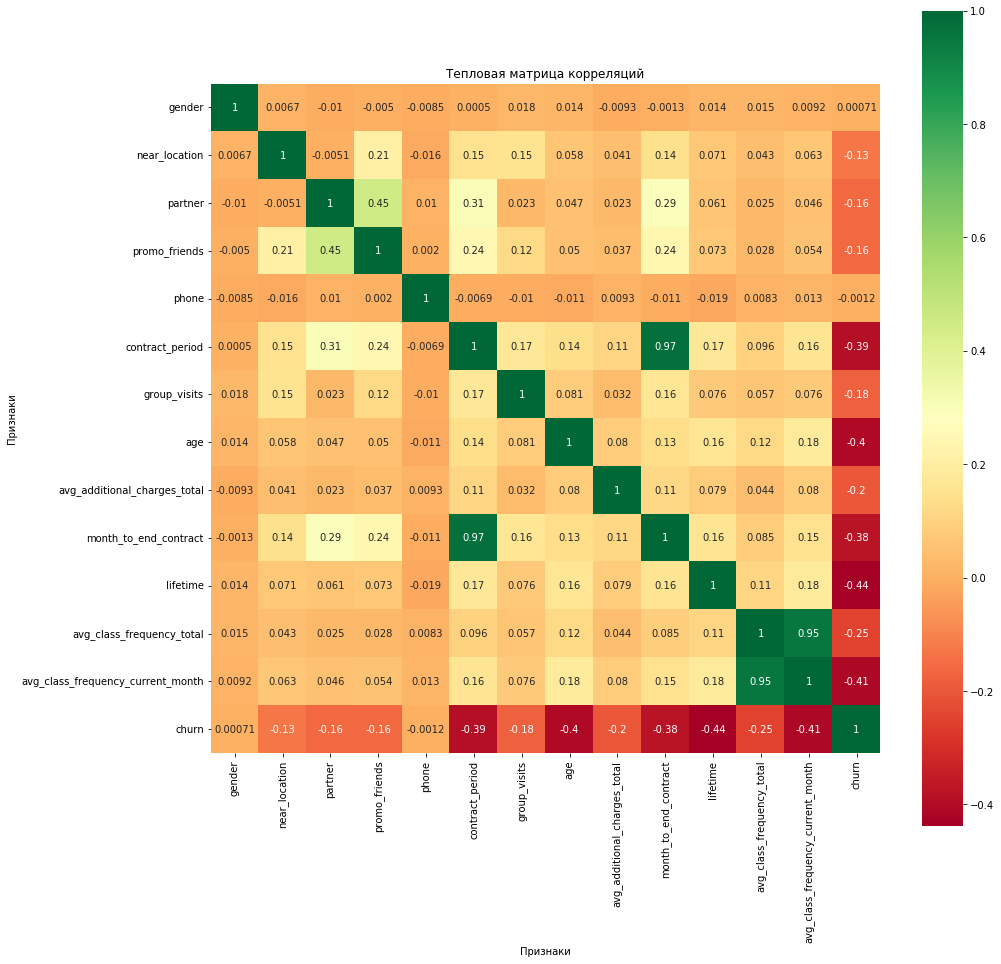

In [15]:
# Построим матрицу корреляций и отобразим её
df=data.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df, annot=True, square=True, cmap="RdYlGn")
plt.title('Тепловая матрица корреляций')
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.show()

Из тепловой матрицы корреляции можно увидеть, что коэффициент корреляции между признаками Avg_class_frequency_total и Avg_class_frequency_current_month, а так же Month_to_end_contract и Contract_period составляет больше 0,9.   

Признаков, которые сильно коррелируют с целевой переменно нет.

Логистическая регрессия относится к линейному классификатору, поэтому могут возникнуть проблемы при расчетах, чтобы этого избежать удалим вручную два признака, сильно коррелирующии с другими.

In [16]:
data = data.drop(['month_to_end_contract', 'avg_class_frequency_current_month' ], axis=1)

### Вывод

1. Исходя из исследовательского анализа, можно составить портрет клиента, который уходит:

* не проживает и не работает в районе фитнес-клуба
* более молодые
* меньше пользуется другими услугами фитнес центра
* длительность текущего абонемента составляет менее 2ух месяцев
* лайфтайм меньше месяца
* посещение в неделю менее двух раз
* тот кто за неделю не посетил фитнес ни разу.
* тот кто не оставляет телефон

2. Так же:
* от пола нет зависимости остаются или уходят клиенты 
* отток меньше у клиентов, являющимися сотрудниками компаний-партнеров.
* остаются больше те, кто пришел не по акции "приведи друга"
* больше все таки  остаются клиенты, чем уходят

3. Коэффициент корреляции между признаками Avg_class_frequency_total и Avg_class_frequency_current_month, а так же Month_to_end_contract и Contract_period составляет больше 0,9. Чтобы избавиться от мультиколлинеарности, удалили из датафрейма два из них.  


4. Графики показали на не сбалансированность классов, отток клиентов не равномерный, уходит в три раза меньше клиентов чем остаются.  

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [17]:
X = data.drop(['churn'], axis=1) # сохраним в переменной матрицу объекты-признаки, удалив из датафрейма колонку с целевой переменной
y = data['churn']# сохраним в переменной колонку со значением целевой переменной


In [18]:
# создадим обучающий набор, выделяя 70% выборок в исходном наборе данных. Следовательно, train_size равен 0,70.
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.70, random_state=0, stratify=y)

In [19]:
# Части X_rem и y_rem относятся к оставшемуся набору данных, который используется для создания 
# проверочных и тестовых наборов на следующем шаге.
X_valid, X_test, y_valid, y_test = train_test_split (X_rem, y_rem, test_size = 0.15, random_state=0)

In [20]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [21]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_valid_st = scaler.transform(X_valid)

# зададим алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_valid_st)
lr_probabilities = lr_model.predict_proba(X_valid_st)[:, 1]

In [22]:
# выведем все метрики
print_all_metrics(
    y_valid,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',)

Метрики для модели логистической регрессии:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79


In [23]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_valid) 
rf_probabilities = rf_model.predict_proba(X_valid)[:, 1]

In [24]:
# выведем все метрики
print_all_metrics(
    y_valid, 
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.88
	Precision: 0.80
	Recall: 0.74


In [25]:
# разделим набор данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

In [26]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и тесмтовые наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear', random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [27]:
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',)


Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.82


In [28]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [29]:
# выведем все метрики
print_all_metrics(
    y_test, 
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.83
	Recall: 0.79


### Вывод
Для валидационной выборки модель логистическая регрессия лучше, все три показателя ближе к 100%. 

Для тестовой выборки у модели логистической регресии, два из трех метрик ближе к 100%, чем у модели случайного леса, таким образом она показала себя лучше. 

## Проведение кластеризации клиентов

In [30]:
# стандартизируем данные перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X) 

In [31]:
# Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков
linked = linkage(X_sc, method = 'ward')

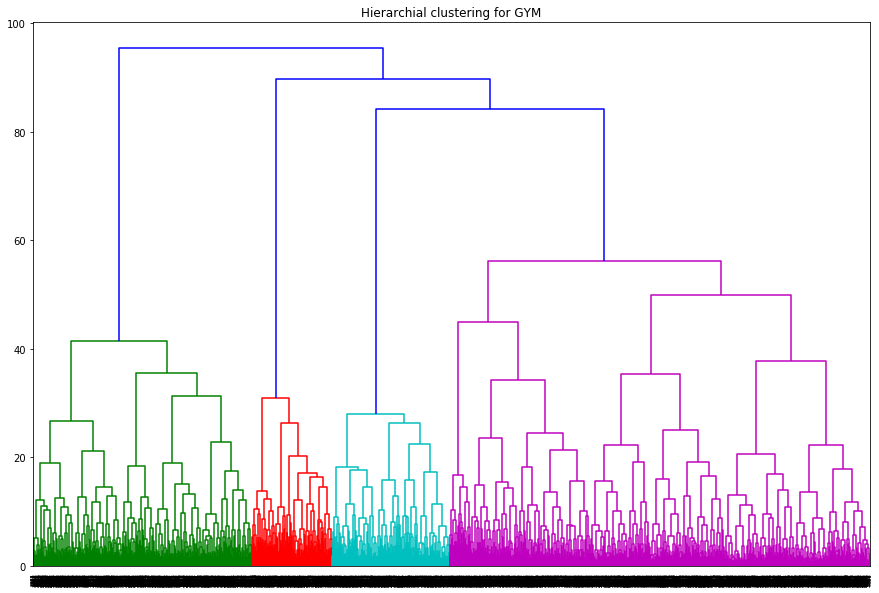

In [32]:
# В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

На основании дендограммы можно выделить 4 кластера.

In [33]:
# задаём число кластеров, равное 5 как указано в задании, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

In [34]:
# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels


In [35]:
# выводим статистику по средним значениям наших признаков по кластеру
cluster_features = data.groupby('cluster_km').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster_km']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,0,0.50,0.00,0.49,0.08,1.00,3.03,0.24,28.72,137.54,3.06,1.77,0.40
1,1,0.49,1.00,0.96,0.89,1.00,7.66,0.46,29.54,155.86,4.38,1.98,0.12
2,2,0.51,1.00,0.24,0.06,1.00,2.82,0.00,28.77,143.38,3.34,1.80,0.38
3,3,0.54,1.00,0.25,0.08,1.00,4.53,1.00,29.54,148.09,3.76,1.94,0.20
4,4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.85,0.27


In [36]:
# посмотрим на число примеров попавших в кластеры после KMeans
cluster_features_1 = data.groupby('cluster_km').count()
cluster_features_1.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

cluster_km,0,1,2,3,4
gender,561,1050,1132,871,386
near_location,561,1050,1132,871,386
partner,561,1050,1132,871,386
promo_friends,561,1050,1132,871,386
phone,561,1050,1132,871,386
contract_period,561,1050,1132,871,386
group_visits,561,1050,1132,871,386
age,561,1050,1132,871,386
avg_additional_charges_total,561,1050,1132,871,386
lifetime,561,1050,1132,871,386


По средним значениям, можно составить характеристики кластеров:
- **Кластер 0**:
   * живут или работают НЕ в районе фитнес-центра
   * оставляют контактный телефон
   * 3 мес. до окончания абонемента
   * всех меньше прибыль за доп. услуги от данных клиентов
   * лайфтайм - 3,7 мес
   * посещают менее 2 раз в неделю зал
- **Кластер 1**:
   * все живут или работают в районе фитнес-центра
   * оставляют контактный телефон
   * всех больше клиентов, являющимися партнерами клуба - 96%
   * 7,6 мес. до окончания абонемента
   * всех больше прибыль за доп. услуги от данных клиентов
   * лайфтайм - 4,38 мес
   * посещают менее 2 раз в неделю зал
- **Кластер 2**:
   * живут или работают в районе фитнес-центра
   * оставляют контактный телефон
   * 2,82 мес. до окончания абонемента
   * лайфтайм - 3,34 мес
   * посещают менее 2 раз в неделю зал
- **Кластер 3**:
   * живут или работают приемущественно в районе фитнес-центра
   * оставляют контактный телефон
   * длительность текущего аббонемента 4,53 мес
   * вторые по средней суммарной выручке от доп. услуг
   * лайфтайм - 3,76 мес
   * посещают более 2 раз в неделю зал
- **Кластер 4**:
   * живут или работают приемущественно в районе фитнес-центра
   * не оставляют контактный телефон
   * самоя большая длительность текущего абонемента - 4,78 мес.  
   * самое большое лайфтайм - 3,94 мес.
   * посещают менее 2 раз в неделю зал

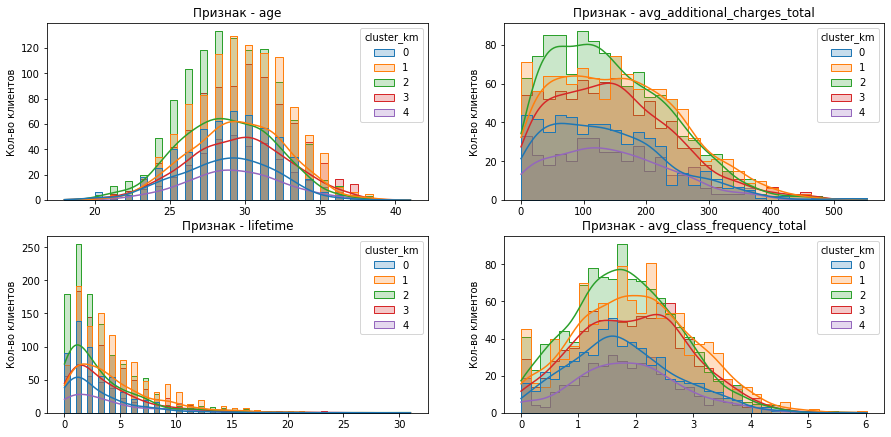

In [37]:
# Построим распределения признаков для кластеров
distplot_columns_2 = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']

plt.figure(figsize=(15, 15))
 
for i, f in enumerate(distplot_columns_2):           
    sns.histplot(data, x=data[f], hue='cluster_km', palette="tab10", element="step", kde=True, ax = plt.subplot(row_count, col_count, i+1)) 
    plt.title(f'Признак - {f}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")

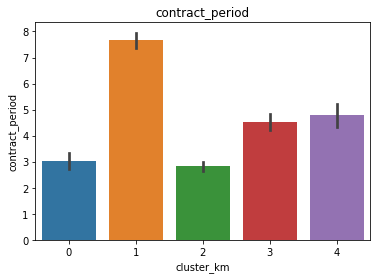

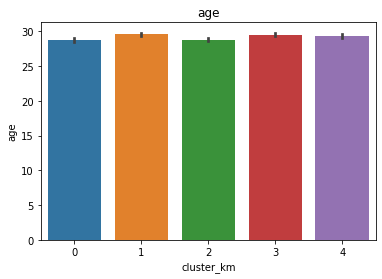

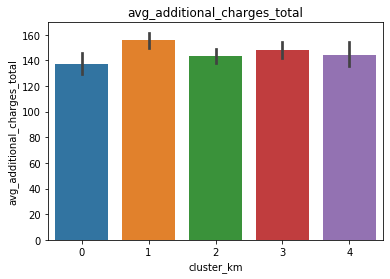

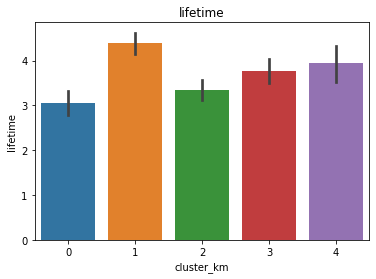

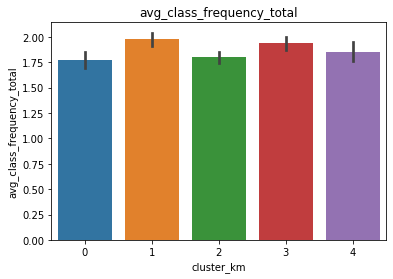

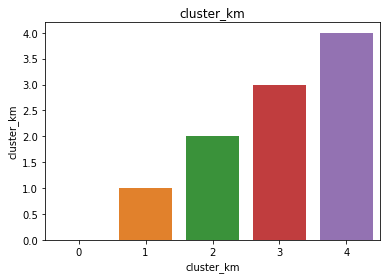

In [38]:
# построим графики по кластерам для оставшихся признаков 
for j in data.columns:
    if j not in distplot_columns_1:
        sns.barplot(data=data, x='cluster_km', y=j)
        plt.title(j)
        plt.show()

Из графиков распределения видно, что характеристики кластеров совпадают, что давали выше, исходя из среднего значения.

In [39]:
# Для каждого полученного кластера посчитаем долю оттока в процентах
round(data.groupby('cluster_km')['churn'].mean()*100, 2)

cluster_km
0    39.93
1    12.10
2    38.16
3    20.09
4    26.68
Name: churn, dtype: float64

Всех больше отток происходит в первом кластере, вех меньше в третьем.

### Вывод

Исходя из составленных выше характеристик каждого кластера, можно предположить, что самым выгодным для бизнеса является кластер 1, так как у него всех меньше отток клиентов, и он приносит всех больше выручки с дополнительных услуг. А всех хуже, является кластер номер 0. У него большой процент оттока и меньше выручка с доп. услуг

## Выводы и рекомендации

I. Данные:

* Получили данные без пропусков, тип признаков у всех числовой.
* В данных были обнаружены выбросы, но так как доля выбросов не велика, удалять их не стали.
* Нашли признаки, которые сильно коррелируют друг с другом (больше 0,9) это Avg_class_frequency_total и Avg_class_frequency_current_month, а так же Month_to_end_contract и Contract_period. Удалили по одному из каждой пары.

II. Моделирование:

* Графики показали на несбалансированность классов, уходят клиентов в три раза меньше, чем остаются, это означает, что могут возникнут сложности с метриками, основанными на бинарных ответах, поэтому при выборе модели мы не сильно ориентировались на метрику accuracy.


* Построили модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Разбили данные на обучающую и валидационную выборку и тестовую выборки. Обучили модель на train-выборке двумя способами:
   * логистической регрессией,
   * случайным лесом.
 

* У модели логистической регресии, все три метрики ближе к 100%, чем у модели случайного леса, таким образом она показала себя лучше.

III. Кластеризация:

* Стандартизировали данные, нарисовали дендрограмму, провели кластеризацию клиентов при помощи алгоритма K-Means. Посмотрели на средние значения признаков для кластеров и построили распределения признаков для кластеров. Получили основные их характеристики.   


* Исходя из проведенного анализа можно спрогнозировать вероятность оттока клиента по ряду признаков:
   * не проживает и не работает в районе фитнес-клуба
   * не является сотрудником компании партнера
   * более молодой
   * меньше пользуется другими доп. услугами фитнес центра
   * длительность текущего абонемента составляет менее месяца
   * время с момента первого обращения меньше месяца
   * не оставляет свой номер телефона
   
   
* После кластеризации клиентов и последующего анализа, были выявлены те кто с большой вероятностью уходят
   в отток и те кто остаются:
   * кластеры 1 и 3 с меньшей вероятностью уходят в отток
   * кластеры 0 и 2 с большей вероятностью уходят в отток
   
   
* Исходя из вышеперечисленного, можно предложить стратегию взаимодействия с клиентами для их удержания, а имеено:
   * предлагать по более привлекательной цене абонементы на 6 и 12 месяцев, чтобы клиенты предпочтительней брали их,      нежели на 1 месяц.
   * увеличить количество сотрудничеств с компаниями, чьи сотрудники могут получать скидки на абонемен, так можно привлечь как      можно больше клиентов
   * делать упор на рекламе именно в том районе, где находится фитнес клуб, чтоб привлекать клиентов живущих или работающих именно в этом районе.
   
   
* Так как мы провели сегментацию клиентов, можно каждому сегменту предложить свои "плюшки" либо 
   для того, чтобы удержать, либо для того, чтобы получить еще больше прибыли с каждого клиента, а именно:
   * клиентам из кластеров 1 и 3, предлагать как можно больше дополнительных услуг, так как они охотно тратятся на них.
   * клиентам из кластеров 0 и 2, предлагать абонементы на более длительный срок по более выгодным условиям, чем абонемеенты на 1 месяц, тем самым уменьшить отток данных клиентов.